In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='50'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs/profiles-v1/profiles-v1-pca'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
INPUT_PT_PATH = f"/workspace/datasets/profiles-v1/profiles-v1-pca/profiles-v1-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v1_pca_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_50_20250721_0352


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_50_20250721_0352/density_plot.png


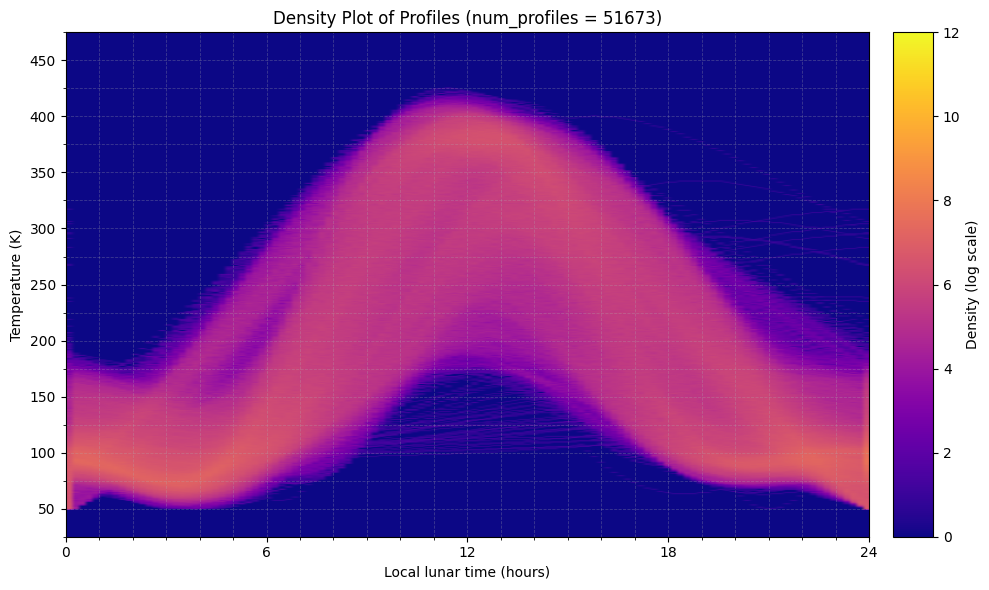

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 189.6376
STD: 96.5165
Min Temp: 50.0020
Max Temp: 424.9460
Datasets:
Training Data: 36171
Validation Data: 10334
Test Data: 5168


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 181/181 [00:05<00:00, 30.93it/s, best_loss=0.8794]


[Training] Epoch 1/100, L1 Loss: 0.8208, L2 Loss: 1.0009, KL Loss: 0.0082, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 52/52 [00:00<00:00, 103.18it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0005
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_50_20250721_0352'


[Training] Epoch 2/100: 100%|██████████| 181/181 [00:05<00:00, 30.26it/s, best_loss=0.8799]


[Training] Epoch 2/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0005, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 52/52 [00:00<00:00, 98.21it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 3/100: 100%|██████████| 181/181 [00:05<00:00, 30.24it/s, best_loss=0.8749]


[Training] Epoch 3/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 52/52 [00:00<00:00, 101.39it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 4/100: 100%|██████████| 181/181 [00:06<00:00, 29.95it/s, best_loss=0.8804]


[Training] Epoch 4/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 52/52 [00:00<00:00, 97.19it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 5/100: 100%|██████████| 181/181 [00:05<00:00, 30.17it/s, best_loss=0.9007]


[Training] Epoch 5/100, L1 Loss: 0.8203, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 52/52 [00:00<00:00, 102.30it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 6/100: 100%|██████████| 181/181 [00:06<00:00, 30.15it/s, best_loss=0.8841]


[Training] Epoch 6/100, L1 Loss: 0.8203, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 52/52 [00:00<00:00, 101.04it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 7/100: 100%|██████████| 181/181 [00:06<00:00, 28.99it/s, best_loss=0.8891]


[Training] Epoch 7/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 52/52 [00:00<00:00, 101.20it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 8/100: 100%|██████████| 181/181 [00:06<00:00, 29.92it/s, best_loss=0.8733]


[Training] Epoch 8/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 52/52 [00:00<00:00, 100.08it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 9/100: 100%|██████████| 181/181 [00:06<00:00, 29.00it/s, best_loss=0.8612]


[Training] Epoch 9/100, L1 Loss: 0.8202, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 52/52 [00:00<00:00, 93.74it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 10/100: 100%|██████████| 181/181 [00:06<00:00, 29.06it/s, best_loss=0.9041]


[Training] Epoch 10/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 52/52 [00:00<00:00, 94.62it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 11/100: 100%|██████████| 181/181 [00:06<00:00, 29.64it/s, best_loss=0.8690]


[Training] Epoch 11/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 52/52 [00:00<00:00, 101.11it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 12/100: 100%|██████████| 181/181 [00:06<00:00, 29.15it/s, best_loss=0.8561]


[Training] Epoch 12/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 52/52 [00:00<00:00, 103.20it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 13/100: 100%|██████████| 181/181 [00:06<00:00, 29.65it/s, best_loss=0.8819]


[Training] Epoch 13/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 52/52 [00:00<00:00, 104.50it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 14/100: 100%|██████████| 181/181 [00:06<00:00, 29.64it/s, best_loss=0.8630]


[Training] Epoch 14/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 52/52 [00:00<00:00, 105.35it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 15/100: 100%|██████████| 181/181 [00:06<00:00, 30.13it/s, best_loss=0.8872]


[Training] Epoch 15/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 52/52 [00:00<00:00, 104.13it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 16/100: 100%|██████████| 181/181 [00:06<00:00, 29.02it/s, best_loss=0.9064]


[Training] Epoch 16/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 52/52 [00:00<00:00, 96.20it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 17/100: 100%|██████████| 181/181 [00:06<00:00, 29.00it/s, best_loss=0.9075]


[Training] Epoch 17/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 52/52 [00:00<00:00, 104.76it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 18/100: 100%|██████████| 181/181 [00:06<00:00, 29.62it/s, best_loss=0.9022]


[Training] Epoch 18/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 52/52 [00:00<00:00, 97.79it/s] 


[Validation] Epoch 18/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 19/100: 100%|██████████| 181/181 [00:06<00:00, 29.68it/s, best_loss=0.9030]


[Training] Epoch 19/100, L1 Loss: 0.8202, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 52/52 [00:00<00:00, 94.72it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 20/100: 100%|██████████| 181/181 [00:06<00:00, 29.96it/s, best_loss=0.8846]


[Training] Epoch 20/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 52/52 [00:00<00:00, 102.53it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 21/100: 100%|██████████| 181/181 [00:06<00:00, 29.75it/s, best_loss=0.8883]


[Training] Epoch 21/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 52/52 [00:00<00:00, 99.72it/s] 


[Validation] Epoch 21/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 22/100: 100%|██████████| 181/181 [00:06<00:00, 28.33it/s, best_loss=0.8727]


[Training] Epoch 22/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 52/52 [00:00<00:00, 98.56it/s] 


[Validation] Epoch 22/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 23/100: 100%|██████████| 181/181 [00:06<00:00, 28.58it/s, best_loss=0.9015]


[Training] Epoch 23/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 52/52 [00:00<00:00, 76.42it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 24/100: 100%|██████████| 181/181 [00:06<00:00, 28.49it/s, best_loss=0.8669]


[Training] Epoch 24/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 52/52 [00:00<00:00, 100.53it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 25/100: 100%|██████████| 181/181 [00:06<00:00, 29.08it/s, best_loss=0.8741]


[Training] Epoch 25/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 52/52 [00:00<00:00, 84.55it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 26/100: 100%|██████████| 181/181 [00:06<00:00, 28.94it/s, best_loss=0.8670]


[Training] Epoch 26/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 52/52 [00:00<00:00, 98.63it/s] 


[Validation] Epoch 26/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 27/100: 100%|██████████| 181/181 [00:06<00:00, 29.43it/s, best_loss=0.8649]


[Training] Epoch 27/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 52/52 [00:00<00:00, 96.25it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 28/100: 100%|██████████| 181/181 [00:06<00:00, 29.44it/s, best_loss=0.8851]


[Training] Epoch 28/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 52/52 [00:00<00:00, 97.93it/s] 


[Validation] Epoch 28/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 29/100: 100%|██████████| 181/181 [00:06<00:00, 29.69it/s, best_loss=0.8800]


[Training] Epoch 29/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 52/52 [00:00<00:00, 99.04it/s] 


[Validation] Epoch 29/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 30/100: 100%|██████████| 181/181 [00:06<00:00, 29.07it/s, best_loss=0.8601]


[Training] Epoch 30/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 52/52 [00:00<00:00, 96.79it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 31/100: 100%|██████████| 181/181 [00:06<00:00, 29.10it/s, best_loss=0.8680]


[Training] Epoch 31/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 52/52 [00:00<00:00, 99.42it/s] 


[Validation] Epoch 31/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 32/100: 100%|██████████| 181/181 [00:06<00:00, 29.24it/s, best_loss=0.9051]


[Training] Epoch 32/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 52/52 [00:00<00:00, 101.47it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 33/100: 100%|██████████| 181/181 [00:06<00:00, 29.49it/s, best_loss=0.8875]


[Training] Epoch 33/100, L1 Loss: 0.8203, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 52/52 [00:00<00:00, 99.77it/s] 


[Validation] Epoch 33/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 34/100: 100%|██████████| 181/181 [00:06<00:00, 29.64it/s, best_loss=0.8744]


[Training] Epoch 34/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 52/52 [00:00<00:00, 97.92it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 35/100: 100%|██████████| 181/181 [00:06<00:00, 28.77it/s, best_loss=0.8652]


[Training] Epoch 35/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 52/52 [00:00<00:00, 100.82it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 36/100: 100%|██████████| 181/181 [00:06<00:00, 29.31it/s, best_loss=0.8836]


[Training] Epoch 36/100, L1 Loss: 0.8203, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 52/52 [00:00<00:00, 98.44it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 37/100: 100%|██████████| 181/181 [00:06<00:00, 29.61it/s, best_loss=0.8721]


[Training] Epoch 37/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 52/52 [00:00<00:00, 87.73it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 38/100: 100%|██████████| 181/181 [00:06<00:00, 29.47it/s, best_loss=0.8718]


[Training] Epoch 38/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 52/52 [00:00<00:00, 99.13it/s] 


[Validation] Epoch 38/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 39/100: 100%|██████████| 181/181 [00:06<00:00, 29.29it/s, best_loss=0.9045]


[Training] Epoch 39/100, L1 Loss: 0.8203, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 52/52 [00:00<00:00, 100.84it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 40/100: 100%|██████████| 181/181 [00:06<00:00, 28.60it/s, best_loss=0.9001]


[Training] Epoch 40/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 52/52 [00:00<00:00, 96.19it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 41/100: 100%|██████████| 181/181 [00:06<00:00, 28.84it/s, best_loss=0.8800]


[Training] Epoch 41/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 52/52 [00:00<00:00, 99.44it/s] 


[Validation] Epoch 41/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 42/100: 100%|██████████| 181/181 [00:06<00:00, 28.72it/s, best_loss=0.9054]


[Training] Epoch 42/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 52/52 [00:00<00:00, 94.46it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 43/100: 100%|██████████| 181/181 [00:06<00:00, 28.98it/s, best_loss=0.8982]


[Training] Epoch 43/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 52/52 [00:00<00:00, 97.37it/s] 


[Validation] Epoch 43/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 44/100: 100%|██████████| 181/181 [00:06<00:00, 28.54it/s, best_loss=0.9077]


[Training] Epoch 44/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 52/52 [00:00<00:00, 100.73it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 45/100: 100%|██████████| 181/181 [00:06<00:00, 28.84it/s, best_loss=0.8930]


[Training] Epoch 45/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 52/52 [00:00<00:00, 96.53it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 46/100: 100%|██████████| 181/181 [00:06<00:00, 28.70it/s, best_loss=0.8710]


[Training] Epoch 46/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 52/52 [00:00<00:00, 102.63it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 47/100: 100%|██████████| 181/181 [00:06<00:00, 29.31it/s, best_loss=0.8775]


[Training] Epoch 47/100, L1 Loss: 0.8203, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 52/52 [00:00<00:00, 101.21it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 48/100: 100%|██████████| 181/181 [00:06<00:00, 29.15it/s, best_loss=0.8936]


[Training] Epoch 48/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 52/52 [00:00<00:00, 95.35it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 49/100: 100%|██████████| 181/181 [00:06<00:00, 29.50it/s, best_loss=0.8650]


[Training] Epoch 49/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 52/52 [00:00<00:00, 86.96it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 50/100: 100%|██████████| 181/181 [00:06<00:00, 28.85it/s, best_loss=0.8898]


[Training] Epoch 50/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 52/52 [00:00<00:00, 94.94it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 51/100: 100%|██████████| 181/181 [00:06<00:00, 28.86it/s, best_loss=0.8875]


[Training] Epoch 51/100, L1 Loss: 0.8202, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 52/52 [00:00<00:00, 85.13it/s] 


[Validation] Epoch 51/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 52/100: 100%|██████████| 181/181 [00:06<00:00, 28.92it/s, best_loss=0.8890]


[Training] Epoch 52/100, L1 Loss: 0.8203, L2 Loss: 1.0002, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 52/52 [00:00<00:00, 99.25it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 53/100: 100%|██████████| 181/181 [00:06<00:00, 28.73it/s, best_loss=0.8615]


[Training] Epoch 53/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 52/52 [00:00<00:00, 95.64it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 54/100: 100%|██████████| 181/181 [00:06<00:00, 28.84it/s, best_loss=0.9097]


[Training] Epoch 54/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 52/52 [00:00<00:00, 96.34it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 55/100: 100%|██████████| 181/181 [00:06<00:00, 28.54it/s, best_loss=0.8701]


[Training] Epoch 55/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 52/52 [00:00<00:00, 100.42it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 56/100: 100%|██████████| 181/181 [00:06<00:00, 29.17it/s, best_loss=0.8807]


[Training] Epoch 56/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 52/52 [00:00<00:00, 93.33it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 57/100: 100%|██████████| 181/181 [00:06<00:00, 28.86it/s, best_loss=0.9023]


[Training] Epoch 57/100, L1 Loss: 0.8203, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 52/52 [00:00<00:00, 101.76it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 58/100: 100%|██████████| 181/181 [00:06<00:00, 29.63it/s, best_loss=0.8848]


[Training] Epoch 58/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 52/52 [00:00<00:00, 101.19it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 59/100: 100%|██████████| 181/181 [00:05<00:00, 30.50it/s, best_loss=0.8939]


[Training] Epoch 59/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 52/52 [00:00<00:00, 96.94it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 60/100: 100%|██████████| 181/181 [00:06<00:00, 29.91it/s, best_loss=0.8697]


[Training] Epoch 60/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 52/52 [00:00<00:00, 101.56it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 61/100: 100%|██████████| 181/181 [00:06<00:00, 29.78it/s, best_loss=0.8906]


[Training] Epoch 61/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 52/52 [00:00<00:00, 101.05it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 62/100: 100%|██████████| 181/181 [00:06<00:00, 29.13it/s, best_loss=0.8930]


[Training] Epoch 62/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 52/52 [00:00<00:00, 101.13it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 63/100: 100%|██████████| 181/181 [00:06<00:00, 28.81it/s, best_loss=0.8729]


[Training] Epoch 63/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 52/52 [00:00<00:00, 96.39it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 64/100: 100%|██████████| 181/181 [00:06<00:00, 29.63it/s, best_loss=0.8032]


[Training] Epoch 64/100, L1 Loss: 0.8202, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 52/52 [00:00<00:00, 100.35it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 65/100: 100%|██████████| 181/181 [00:06<00:00, 29.63it/s, best_loss=0.8796]


[Training] Epoch 65/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 52/52 [00:00<00:00, 98.10it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 66/100: 100%|██████████| 181/181 [00:06<00:00, 29.72it/s, best_loss=0.9006]


[Training] Epoch 66/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 52/52 [00:00<00:00, 100.41it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 67/100: 100%|██████████| 181/181 [00:06<00:00, 29.15it/s, best_loss=0.8895]


[Training] Epoch 67/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 52/52 [00:00<00:00, 95.44it/s] 


[Validation] Epoch 67/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 68/100: 100%|██████████| 181/181 [00:06<00:00, 29.01it/s, best_loss=0.8992]


[Training] Epoch 68/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 52/52 [00:00<00:00, 98.33it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 69/100: 100%|██████████| 181/181 [00:06<00:00, 29.60it/s, best_loss=0.8971]


[Training] Epoch 69/100, L1 Loss: 0.8203, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 52/52 [00:00<00:00, 94.64it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 70/100: 100%|██████████| 181/181 [00:06<00:00, 29.47it/s, best_loss=0.8910]


[Training] Epoch 70/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 52/52 [00:00<00:00, 102.72it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 71/100: 100%|██████████| 181/181 [00:06<00:00, 29.71it/s, best_loss=0.8967]


[Training] Epoch 71/100, L1 Loss: 0.8202, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 52/52 [00:00<00:00, 101.11it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 72/100: 100%|██████████| 181/181 [00:06<00:00, 28.89it/s, best_loss=0.8831]


[Training] Epoch 72/100, L1 Loss: 0.8203, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 52/52 [00:00<00:00, 100.69it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 73/100: 100%|██████████| 181/181 [00:06<00:00, 29.60it/s, best_loss=0.8826]


[Training] Epoch 73/100, L1 Loss: 0.8202, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 52/52 [00:00<00:00, 102.59it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 74/100: 100%|██████████| 181/181 [00:06<00:00, 29.10it/s, best_loss=0.8634]


[Training] Epoch 74/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 52/52 [00:00<00:00, 96.68it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 75/100: 100%|██████████| 181/181 [00:06<00:00, 29.02it/s, best_loss=0.8634]


[Training] Epoch 75/100, L1 Loss: 0.8202, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 52/52 [00:00<00:00, 96.97it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 76/100: 100%|██████████| 181/181 [00:06<00:00, 29.24it/s, best_loss=0.8877]


[Training] Epoch 76/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 52/52 [00:00<00:00, 95.73it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 77/100: 100%|██████████| 181/181 [00:06<00:00, 29.35it/s, best_loss=0.8865]


[Training] Epoch 77/100, L1 Loss: 0.8202, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 52/52 [00:00<00:00, 96.53it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 78/100: 100%|██████████| 181/181 [00:06<00:00, 29.68it/s, best_loss=0.8800]


[Training] Epoch 78/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 52/52 [00:00<00:00, 102.58it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 79/100: 100%|██████████| 181/181 [00:06<00:00, 28.86it/s, best_loss=0.8632]


[Training] Epoch 79/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 52/52 [00:00<00:00, 85.77it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 80/100: 100%|██████████| 181/181 [00:06<00:00, 29.21it/s, best_loss=0.8888]


[Training] Epoch 80/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 52/52 [00:00<00:00, 100.93it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 81/100: 100%|██████████| 181/181 [00:06<00:00, 28.67it/s, best_loss=0.8918]


[Training] Epoch 81/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 52/52 [00:00<00:00, 95.31it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 82/100: 100%|██████████| 181/181 [00:06<00:00, 29.14it/s, best_loss=0.8977]


[Training] Epoch 82/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 52/52 [00:00<00:00, 96.69it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 83/100: 100%|██████████| 181/181 [00:06<00:00, 29.51it/s, best_loss=0.8783]


[Training] Epoch 83/100, L1 Loss: 0.8202, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 52/52 [00:00<00:00, 95.74it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 84/100: 100%|██████████| 181/181 [00:06<00:00, 29.77it/s, best_loss=0.9144]


[Training] Epoch 84/100, L1 Loss: 0.8202, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 52/52 [00:00<00:00, 96.06it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 85/100: 100%|██████████| 181/181 [00:06<00:00, 29.48it/s, best_loss=0.8895]


[Training] Epoch 85/100, L1 Loss: 0.8203, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 52/52 [00:00<00:00, 101.73it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 86/100: 100%|██████████| 181/181 [00:06<00:00, 29.43it/s, best_loss=0.9096]


[Training] Epoch 86/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 52/52 [00:00<00:00, 100.89it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 87/100: 100%|██████████| 181/181 [00:06<00:00, 29.52it/s, best_loss=0.8939]


[Training] Epoch 87/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 52/52 [00:00<00:00, 98.17it/s] 


[Validation] Epoch 87/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 88/100: 100%|██████████| 181/181 [00:06<00:00, 29.24it/s, best_loss=0.9028]


[Training] Epoch 88/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 52/52 [00:00<00:00, 95.93it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 89/100: 100%|██████████| 181/181 [00:06<00:00, 29.14it/s, best_loss=0.8941]


[Training] Epoch 89/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 52/52 [00:00<00:00, 95.01it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 90/100: 100%|██████████| 181/181 [00:06<00:00, 28.60it/s, best_loss=0.8764]


[Training] Epoch 90/100, L1 Loss: 0.8203, L2 Loss: 1.0001, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 52/52 [00:00<00:00, 95.85it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 91/100: 100%|██████████| 181/181 [00:06<00:00, 28.63it/s, best_loss=0.8710]


[Training] Epoch 91/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 52/52 [00:00<00:00, 97.98it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 92/100: 100%|██████████| 181/181 [00:06<00:00, 29.23it/s, best_loss=0.9104]


[Training] Epoch 92/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 52/52 [00:00<00:00, 100.32it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 93/100: 100%|██████████| 181/181 [00:06<00:00, 29.41it/s, best_loss=0.8923]


[Training] Epoch 93/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 52/52 [00:00<00:00, 100.90it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 94/100: 100%|██████████| 181/181 [00:06<00:00, 29.50it/s, best_loss=0.8719]


[Training] Epoch 94/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 52/52 [00:00<00:00, 94.76it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 95/100: 100%|██████████| 181/181 [00:06<00:00, 29.54it/s, best_loss=0.9039]


[Training] Epoch 95/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 52/52 [00:00<00:00, 99.76it/s] 


[Validation] Epoch 95/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 96/100: 100%|██████████| 181/181 [00:06<00:00, 29.03it/s, best_loss=0.8575]


[Training] Epoch 96/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 52/52 [00:00<00:00, 102.73it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 97/100: 100%|██████████| 181/181 [00:06<00:00, 29.02it/s, best_loss=0.8985]


[Training] Epoch 97/100, L1 Loss: 0.8202, L2 Loss: 0.9999, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 52/52 [00:00<00:00, 100.93it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 98/100: 100%|██████████| 181/181 [00:06<00:00, 28.98it/s, best_loss=0.8629]


[Training] Epoch 98/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 52/52 [00:00<00:00, 95.81it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0004


[Training] Epoch 99/100: 100%|██████████| 181/181 [00:06<00:00, 29.30it/s, best_loss=0.8986]


[Training] Epoch 99/100, L1 Loss: 0.8202, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 52/52 [00:00<00:00, 90.42it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


[Training] Epoch 100/100: 100%|██████████| 181/181 [00:06<00:00, 28.84it/s, best_loss=0.8931]


[Training] Epoch 100/100, L1 Loss: 0.8203, L2 Loss: 1.0000, KL Loss: 0.0004, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 52/52 [00:00<00:00, 99.67it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.8205, Val L2 Loss: 1.0002, Val KL Loss: 0.0003


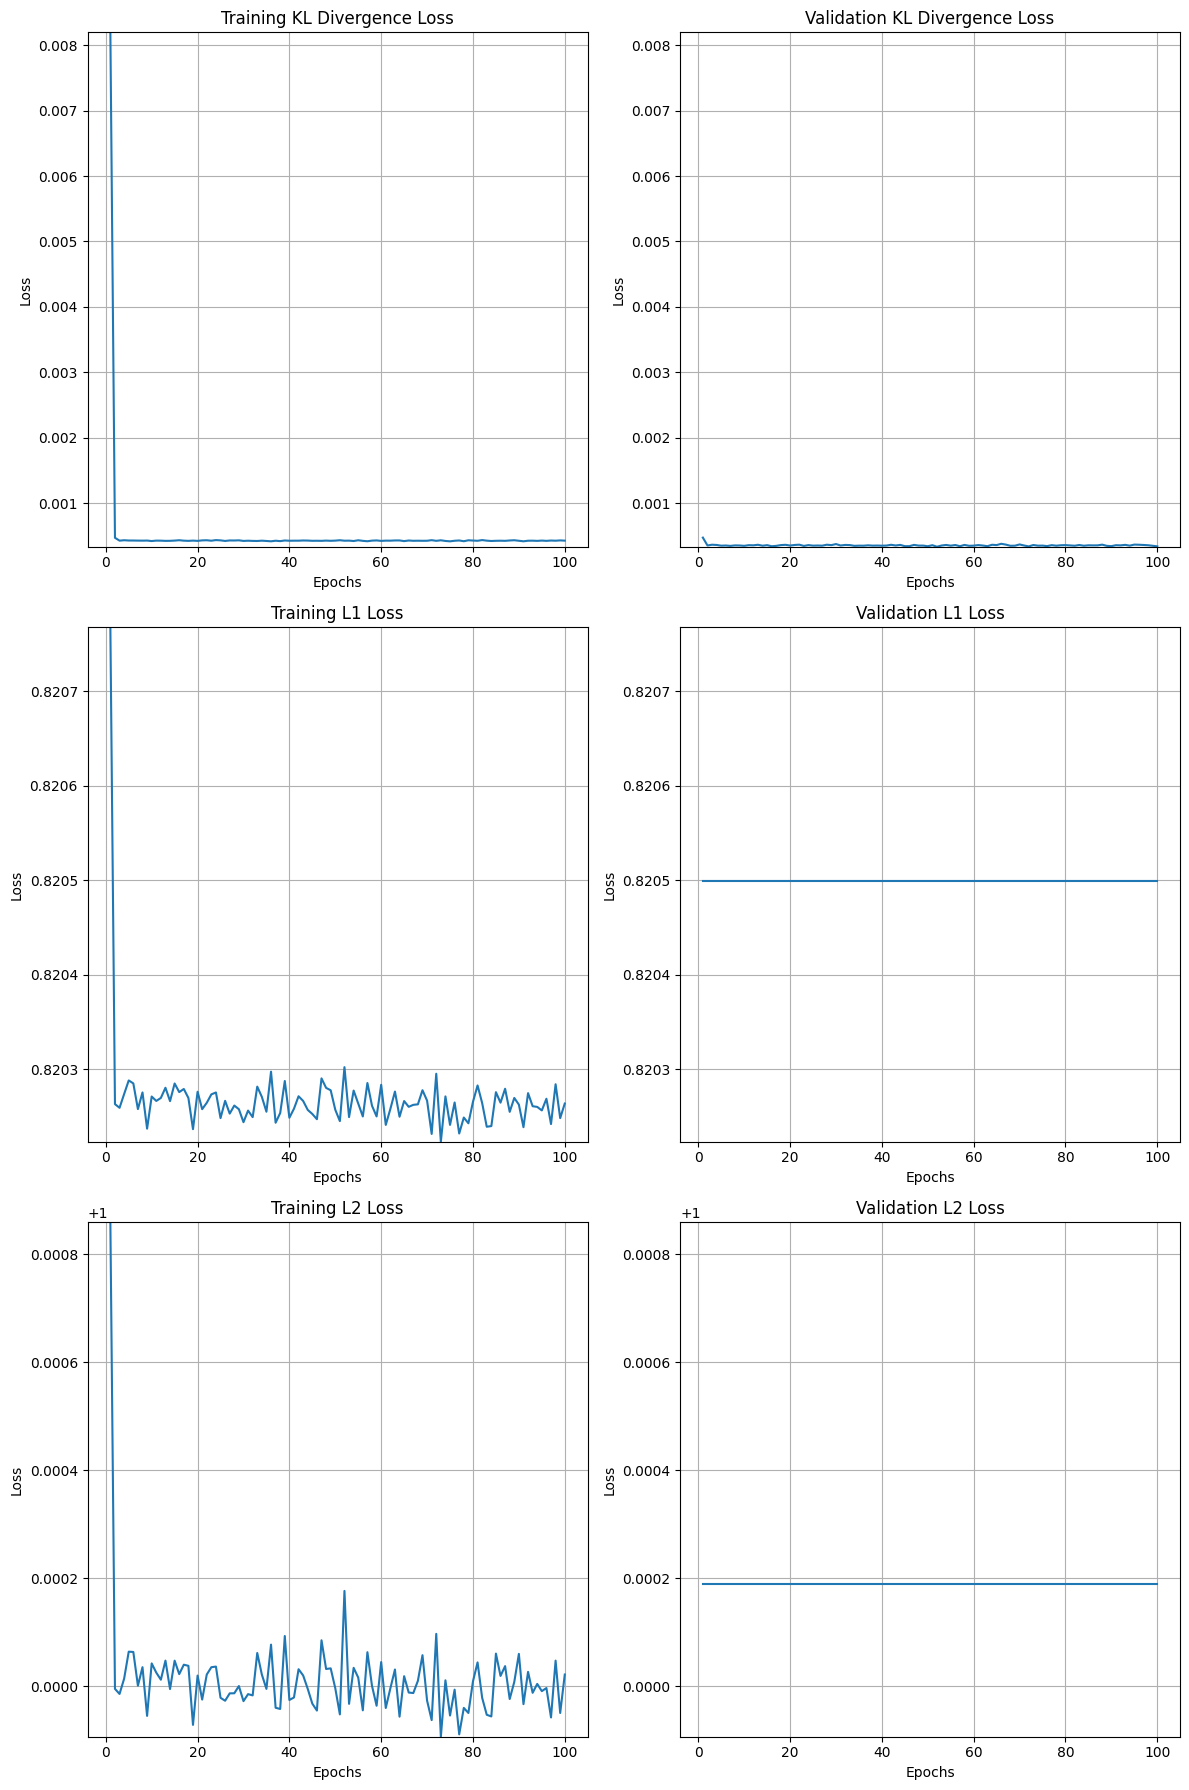

Best Validation Loss in Kelvins:
79.1917 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 3/3 [00:08<00:00,  2.98s/it]


z0: 0.0024
z1: -0.0015
z2: -0.0037
z3: 0.0036


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 676.60it/s]


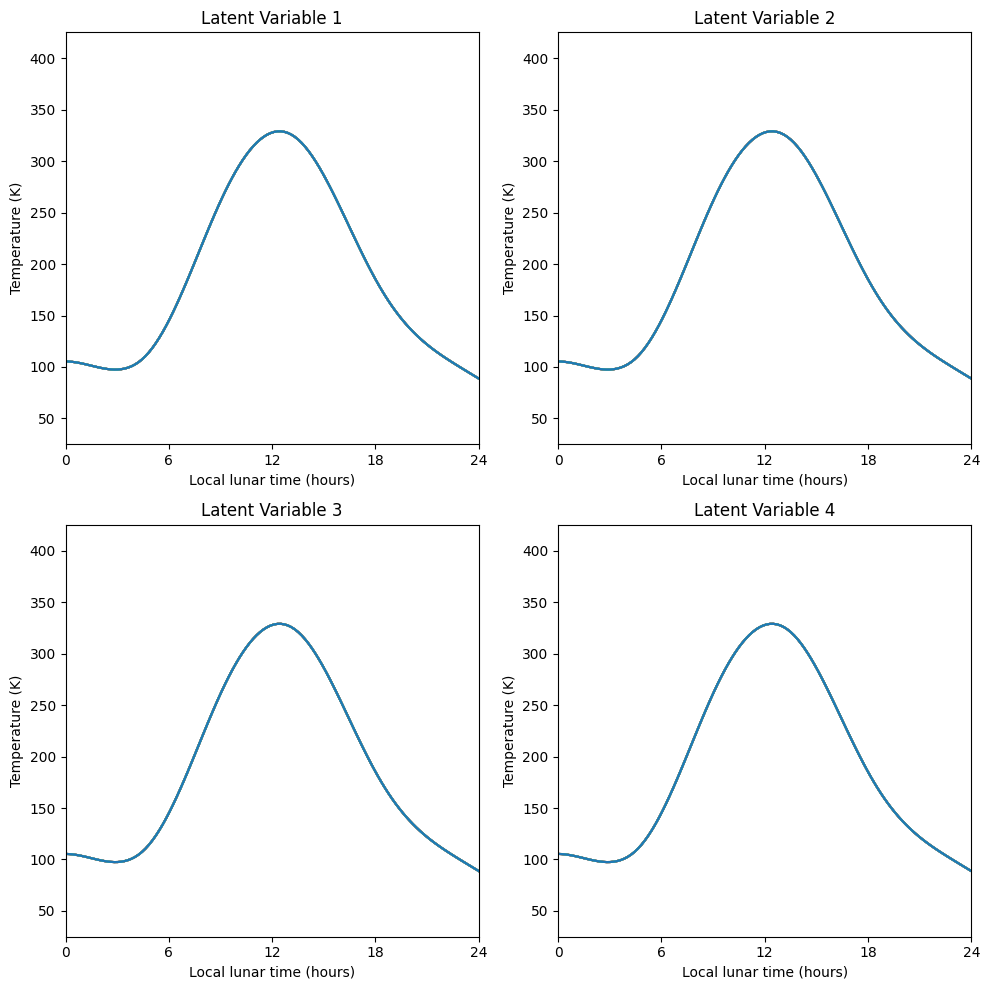

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)